In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sktime.regression.interval_based import TimeSeriesForestRegressor
from sktime.split import temporal_train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
csv_path = os.path.join(notebook_dir, '..', 'data/')

In [ ]:
def load_exchange_data(filename):
    """Load currency exchange data from csv file"""
    full_path = os.path.join(csv_path, filename)
    df = pd.read_csv(full_path)
    return df

df_vnd = load_exchange_data('vnd_data_clean.csv')
df_brl = load_exchange_data('brl_data_clean.csv')
df_hnl = load_exchange_data('hnl_data_clean.csv')
df_idr = load_exchange_data('idr_data_clean.csv')

# Load commodity prices data
commodity_path = os.path.join(csv_path, 'global_commodity_prices.csv')
df_commodity = pd.read_csv(commodity_path)

# Combine all data into one dataframe
merged_df = df_brl.copy()
for df in [df_vnd, df_hnl, df_idr, df_commodity]:
    merged_df = pd.merge(merged_df, df, on="Date", how="inner")
    
merged_df["Date"] = pd.to_datetime(merged_df["Date"], errors="coerce", format="%m/%Y")
merged_df["Date"] = pd.PeriodIndex(merged_df["Date"], freq="M")

In [25]:
merged_df

,Date,brl Exchange Rate,vnd Exchange Rate,hnl Exchange Rate,idr Exchange Rate,Coffee,Milk,Sugar,Tea
0,1990-01,0.000006,5479.329529,2.0000,1804.850000,0.758300,NaN,0.142000,1.147273
1,1990-02,0.000010,5479.329529,2.0000,1809.870000,0.840100,NaN,0.146500,0.958396
2,1990-03,0.000016,5479.329529,4.0000,1820.350000,0.939600,NaN,0.153100,0.873620
3,1990-04,0.000021,5479.329529,4.0000,1826.050000,0.937300,NaN,0.152400,0.883644
4,1990-05,0.000023,5563.430866,4.2000,1831.400000,0.920200,NaN,0.146200,0.848309
...,...,...,...,...,...,...,...,...,...
414,2024-07,5.541448,24251.560000,24.8582,16261.652826,2.570987,0.242129,0.193517,1.363518
415,2024-08,5.552014,24245.850000,24.8826,15793.181818,2.614377,0.244700,0.184195,1.467152
416,2024-09,5.540967,24163.540000,24.8381,15341.250000,2.787605,0.251466,0.206248,1.572990
417,2024-10,5.623509,24192.520000,24.9661,15541.347826,2.767774,0.238592,0.223552,1.490232


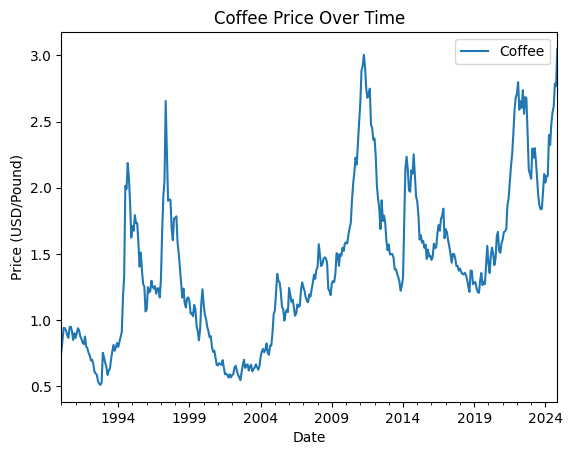

In [27]:
merged_df.plot(x='Date', y='Coffee', title='Coffee Price Over Time')  
plt.xlabel('Date')
plt.ylabel('Price (USD/Pound)')
plt.show()

In [29]:
window_size = 30 # number of historical observations to use for prediction
X = []
y = []
for i in range(len(merged_df) - window_size):
    X.append(merged_df['Coffee'].iloc[i:i+window_size].values)
    y.append(merged_df['Coffee'].iloc[i+window_size])

X = np.array(X).reshape(-1, window_size)
y = np.array(y)

In [31]:
X_train, X_test, y_train, y_test = temporal_train_test_split(X, y, test_size=0.2)
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 311, Test size: 78


In [32]:
regressor = TimeSeriesForestRegressor(
    n_estimators=100,
    min_interval=3,
    random_state=42
)

regressor.fit(X_train, y_train)

TimeSeriesForestRegressor(n_estimators=100, random_state=42)

In [34]:
y_pred = regressor.predict(X_test)
y_pred

array([1.50462461, 1.59427713, 1.66363341, 1.68469477, 1.6880095 ,
       1.68012181, 1.74125241, 1.74169758, 1.6794806 , 1.63568436,
       1.6462339 , 1.66611321, 1.63380931, 1.60211256, 1.64704887,
       1.62452644, 1.58943477, 1.57736422, 1.60303512, 1.61864578,
       1.60546368, 1.72857377, 1.57910063, 1.61319327, 1.55842835,
       1.57227475, 1.60603759, 1.54442271, 1.58076774, 1.72259435,
       1.66113783, 1.61022725, 1.66229314, 1.67973636, 1.70477441,
       1.64898469, 1.67002914, 1.66277935, 1.70451471, 1.87043952,
       1.93051666, 2.17084025, 2.44269668, 2.63165609, 2.71058568,
       2.74425635, 2.68876228, 2.67128567, 2.63881206, 2.5580904 ,
       2.47878085, 2.35788216, 2.30448094, 2.23735665, 2.18922749,
       2.11182889, 1.99489384, 1.89099343, 1.88672554, 1.91357968,
       1.88337047, 1.94102404, 1.9379412 , 1.88179256, 1.79417961,
       1.72523947, 1.71481473, 1.773566  , 1.69689508, 1.81608387,
       1.73441842, 1.79938142, 1.8045391 , 2.03620112, 2.13868

In [35]:
def print_metrics(y_true, y_pred):
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R²: {r2_score(y_true, y_pred):.2f}")

print_metrics(y_test, y_pred)

MAE: 0.26
MSE: 0.10
RMSE: 0.31
R²: 0.64


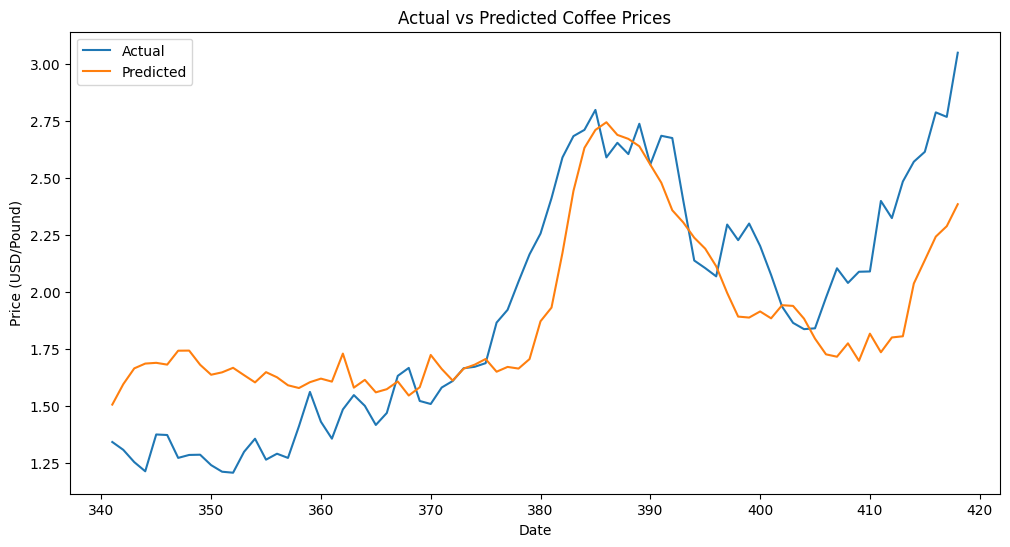

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index[-len(y_test):], y_test, label='Actual')
plt.plot(merged_df.index[-len(y_test):], y_pred, label='Predicted')
plt.title('Actual vs Predicted Coffee Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD/Pound)')
plt.legend()
plt.show()